In [44]:
import tensorflow as tf
print(tf.config.list_physical_devices('GPU'))

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [45]:
tf.config.list_physical_devices('GPU')
tf.test.is_gpu_available()


True

In [46]:
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  1


In [47]:
import tensorflow as tf
from zipfile import ZipFile
import os,glob
import cv2
from tqdm.notebook import tqdm_notebook as tqdm
import numpy as np
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from keras.models import Sequential
from keras.layers import Convolution2D, Dropout, Dense,MaxPooling2D
from keras.layers import BatchNormalization
from keras.layers import MaxPooling2D
from keras.layers import Flatten
from zipfile import ZipFile
import numpy as np
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import pandas as pd
from keras.callbacks import ModelCheckpoint

In [48]:
import sys
from PIL import Image
sys.modules['Image'] = Image 

In [49]:
from PIL import Image
print(Image.__file__)

c:\Users\LEGION\anaconda3\envs\python310\lib\site-packages\PIL\Image.py


In [50]:
import Image
print(Image.__file__)

c:\Users\LEGION\anaconda3\envs\python310\lib\site-packages\PIL\Image.py


In [51]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [52]:
# scale_datagen = ImageDataGenerator(rescale=1./255,
#                                    validation_split=0.3)

# scale_datagen = ImageDataGenerator(rescale=1./255)
from tensorflow.keras.applications.efficientnet import preprocess_input

# datagen = ImageDataGenerator(preprocessing_function=preprocess_input)
datagen = ImageDataGenerator()

In [70]:
# train_dir = r"D:\PROJECT\2_COMPUTER VISION\Image Segmentation\Augmented"
# # train_dir = '/content/drive/MyDrive/Colab Skripsi/DATASETNEW/2_Augmented'
# # val_dir = '/content/drive/MyDrive/Colab Skripsi/DATASETNEW/2_Split/val'
# # test_dir = '/content/drive/MyDrive/Colab Skripsi/DATASETNEW/2_Split/test'


train_dir = r"D:\PROJECT\2_COMPUTER VISION\Image Segmentation\Data Train Gabungan"
val_dir = r"D:\PROJECT\2_COMPUTER VISION\Image Segmentation\Data Val Gabungan"
test_dir = r"D:\PROJECT\2_COMPUTER VISION\Image Segmentation\SPLIT\test"

In [54]:
train_generator = datagen.flow_from_directory(
    train_dir,
    # subset='training',
    target_size=(300, 300),
    batch_size=40,
    class_mode='categorical'
)

Found 20412 images belonging to 4 classes.


In [55]:
val_generator = datagen.flow_from_directory(
    val_dir,
    # subset='validation',
    target_size=(300, 300),
    batch_size=40,
    class_mode='categorical'
)

Found 5823 images belonging to 4 classes.


In [56]:
test_generator = datagen.flow_from_directory(
    test_dir,
    # subset='validation',
    target_size=(300, 300),
    batch_size=40,
    class_mode='categorical'
)

Found 327 images belonging to 4 classes.


In [57]:
print(len(train_generator))
print(len(val_generator))
print(len(test_generator))

511
146
9


In [58]:
# jadi ini modelnya kek gausah bikin dari nol lagi tapi pake arsitektur yang udah ada

from keras.applications import EfficientNetB3
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten, GlobalAveragePooling2D
from keras.layers import Conv2D, MaxPooling2D, ZeroPadding2D

from keras.models import Model

# SET DIMENSI INPUTNYA
img_rows, img_cols = 300, 300

# model learningnya based on imagenet dataset jadi weightnya set ke imagenet
# top layer diganti soalnya outputnya ada 20k neuron, tapi kita cuma butuh 4 neuron soalnya outputnya kan cuma 4
# ini download model yang udah ada jadi pake model efficientnetb3
efficientnet = EfficientNetB3(weights = "imagenet",
                  include_top = False,
                  input_shape = (img_rows, img_cols, 3))

# Ngefreeze 4 layer terkahir
# Layers yang di set ke trainable defaultnya True

# for layer in efficientnet.layers:
#   layer.trainable = False

# ini coba freeze semua layer selain 10 layer terakhir
for layer in efficientnet.layers[:-10]: 
    layer.trainable = False


# ngeprint semua layernya
for (i, layer) in enumerate(efficientnet.layers):
  print(str(i) + " "+ layer.__class__.__name__, layer.trainable)

0 InputLayer False
1 Rescaling False
2 Normalization False
3 TFOpLambda False
4 ZeroPadding2D False
5 Conv2D False
6 BatchNormalization False
7 Activation False
8 DepthwiseConv2D False
9 BatchNormalization False
10 Activation False
11 GlobalAveragePooling2D False
12 Reshape False
13 Conv2D False
14 Conv2D False
15 Multiply False
16 Conv2D False
17 BatchNormalization False
18 DepthwiseConv2D False
19 BatchNormalization False
20 Activation False
21 GlobalAveragePooling2D False
22 Reshape False
23 Conv2D False
24 Conv2D False
25 Multiply False
26 Conv2D False
27 BatchNormalization False
28 Dropout False
29 Add False
30 Conv2D False
31 BatchNormalization False
32 Activation False
33 ZeroPadding2D False
34 DepthwiseConv2D False
35 BatchNormalization False
36 Activation False
37 GlobalAveragePooling2D False
38 Reshape False
39 Conv2D False
40 Conv2D False
41 Multiply False
42 Conv2D False
43 BatchNormalization False
44 Conv2D False
45 BatchNormalization False
46 Activation False
47 Depthwise

In [59]:
# tambahin beberapa layer ke model itu tadi

# def lw(bottom_model, num_classes):
#   """"creates the top or head of the model that will be
#   placed ontop of the bottom layers"""

#   top_model = bottom_model.output
#   top_model = GlobalAveragePooling2D()(top_model)
#   top_model = Dense(1024,activation="relu")(top_model)
#   top_model = Dense(1024,activation="relu")(top_model)
#   top_model = Dense(512,activation="relu")(top_model)
#   top_model = Dense(num_classes,activation='softmax')(top_model) #last output layer, number of classes = 4
#   return top_model

def lw(bottom_model, num_classes):
    top_model = bottom_model.output
    top_model = GlobalAveragePooling2D()(top_model)
    top_model = Dense(512, activation="relu")(top_model)
    top_model = Dense(256, activation="relu")(top_model)
    top_model = Dropout(0.5)(top_model)  # Dropout buat mencegah overfitting
    top_model = Dense(num_classes, activation='softmax')(top_model)  
    return top_model


In [60]:
# itu tadi udah dibikin function lw nya, secara function lwnya di call

# jumlah class nya 2 soalnya yes sama no
num_classes = 4

FC_Head = lw(efficientnet, num_classes)

model = Model(inputs = efficientnet.input, outputs = FC_Head)

print(model.summary())

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, 300, 300, 3  0           []                               
                                )]                                                                
                                                                                                  
 rescaling_2 (Rescaling)        (None, 300, 300, 3)  0           ['input_3[0][0]']                
                                                                                                  
 normalization_2 (Normalization  (None, 300, 300, 3)  7          ['rescaling_2[0][0]']            
 )                                                                                                
                                                                                            

In [61]:
# compile modelnya
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import Precision, Recall
# model.compile(optimizer='adam', loss = 'categorical_crossentropy',metrics = ['accuracy'])


# Set learning rate
learning_rate = 0.001
optimizer = Adam(learning_rate=learning_rate)

# Compile model
model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy', Precision(), Recall()])

In [62]:
# training mulai
filepath=r'D:\PROJECT\SKRIPSI\skripsi_efficientnetb3_001_augment_2.model.keras'
checkpoint = ModelCheckpoint(filepath=filepath,
                             monitor='val_accuracy',
                             save_best_only=True,
                             mode='max',
                             verbose=1)
history = model.fit(train_generator,
                    epochs=30,
                    validation_data=(val_generator),
                    initial_epoch=0,
                    callbacks=[checkpoint])


# # training mulai

# history = model.fit(train_generator,
#                     epochs=10,
#                     validation_data=(val_generator),
#                     verbose = 1,
#                     initial_epoch=0)

Epoch 1/30
511/511 [==============================] - ETA: 0s - loss: 0.3266 - accuracy: 0.8774 - precision_2: 0.9042 - recall_2: 0.8518
Epoch 1: val_accuracy improved from -inf to 0.91070, saving model to D:\PROJECT\SKRIPSI\skripsi_efficientnetb3_001_augment_2.model.keras
511/511 [==============================] - 188s 341ms/step - loss: 0.3266 - accuracy: 0.8774 - precision_2: 0.9042 - recall_2: 0.8518 - val_loss: 0.2542 - val_accuracy: 0.9107 - val_precision_2: 0.9171 - val_recall_2: 0.9080
Epoch 2/30
511/511 [==============================] - ETA: 0s - loss: 0.1827 - accuracy: 0.9320 - precision_2: 0.9421 - recall_2: 0.9239
Epoch 2: val_accuracy improved from 0.91070 to 0.94779, saving model to D:\PROJECT\SKRIPSI\skripsi_efficientnetb3_001_augment_2.model.keras
511/511 [==============================] - 171s 335ms/step - loss: 0.1827 - accuracy: 0.9320 - precision_2: 0.9421 - recall_2: 0.9239 - val_loss: 0.1433 - val_accuracy: 0.9478 - val_precision_2: 0.9552 - val_recall_2: 0.9378

In [63]:
# SAVE MODEL
save_path = r"D:\PROJECT\SKRIPSI\efficientnetb3_augment_2.h5"
model.save(save_path)

In [64]:
# SAVE MODEL
weights_path = r"D:\PROJECT\SKRIPSI\efficientnetb3_augment_2_weights.h5"
model.save_weights(weights_path)

EVALUASI

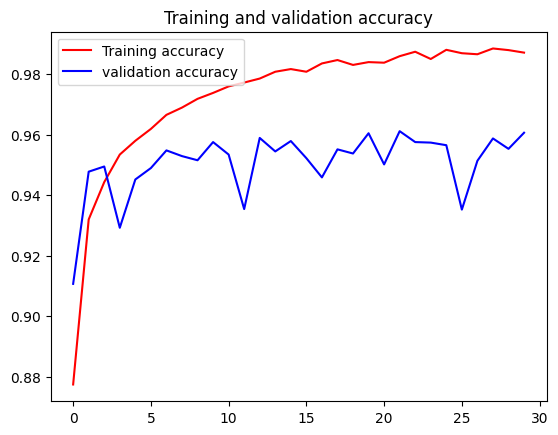

<Figure size 640x480 with 0 Axes>

In [65]:
import matplotlib.pyplot as plt
%matplotlib inline
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'r', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='validation accuracy')
plt.title('Training and validation accuracy')
plt.legend(loc='upper left')
plt.figure()

plt.show()

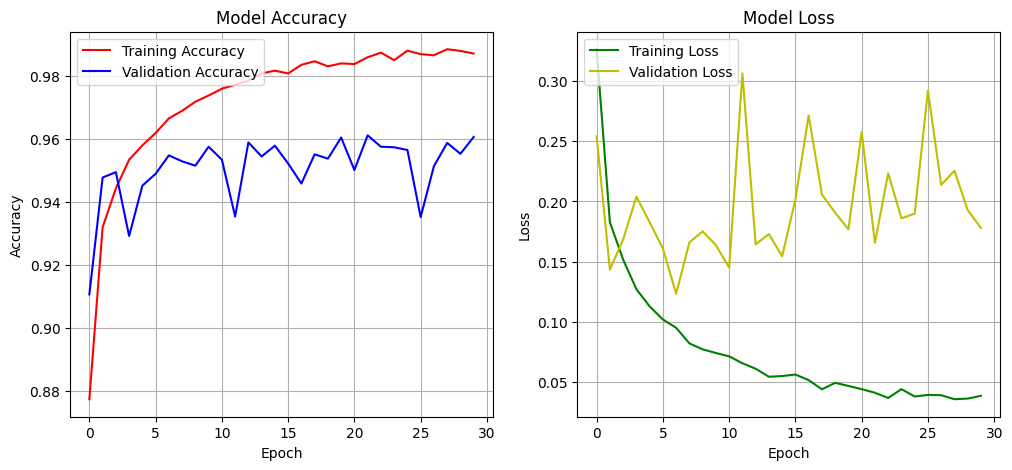

In [66]:
# Grafik plot value accuracy training sama validation
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(acc, 'r', label='Training Accuracy')
plt.plot(val_acc, 'b', label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(loc='upper left')
plt.grid(True)

# Grafik plot value loss training sama validation
plt.subplot(1, 2, 2)
plt.plot(loss, 'g', label='Training Loss')
plt.plot(val_loss, 'y', label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(loc='upper left')
plt.grid(True)

plt.show()

In [71]:
from tensorflow import keras

# Load the trained model
model = keras.models.load_model("efficientnetb3_augment_2.h5")



In [72]:
import numpy as np
from tensorflow.keras.preprocessing.image import ImageDataGenerator

img_size = (300, 300)
batch_size = 40

test_datagen = ImageDataGenerator()

test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=img_size,
    batch_size=batch_size,
    class_mode="categorical",  # Change to 'categorical' if multi-class
    shuffle=False
)

# Get true labels
true_labels = test_generator.classes


Found 327 images belonging to 4 classes.


In [73]:
# Get predictions (probabilities for each class)
pred_probs = model.predict(test_generator)

# Convert probabilities to class labels (index of max probability)
pred_labels = np.argmax(pred_probs, axis=1)  # Gets the class with the highest probability


9/9 [==============================] - 10s 850ms/step


In [74]:
from sklearn.metrics import confusion_matrix

# Compute confusion matrix
cm = confusion_matrix(true_labels, pred_labels)

# Print the confusion matrix
print("Confusion Matrix:")
print(cm)


Confusion Matrix:
[[99  0  0  0]
 [ 1 95  0  0]
 [ 0  1 78  1]
 [ 1  0  1 50]]


In [75]:
from sklearn.metrics import classification_report, accuracy_score

# label class
class_labels = list(test_generator.class_indices.keys())

# classification report
print("Classification Report:")
print(classification_report(true_labels, pred_labels, target_names=class_labels, digits=4))

# akurasi
accuracy = accuracy_score(true_labels, pred_labels)
print(f"Accuracy: {accuracy:.4f}")


Classification Report:
              precision    recall  f1-score   support

   EarlyPreB     0.9802    1.0000    0.9900        99
        PreB     0.9896    0.9896    0.9896        96
        ProB     0.9873    0.9750    0.9811        80
      benign     0.9804    0.9615    0.9709        52

    accuracy                         0.9847       327
   macro avg     0.9844    0.9815    0.9829       327
weighted avg     0.9847    0.9847    0.9847       327

Accuracy: 0.9847


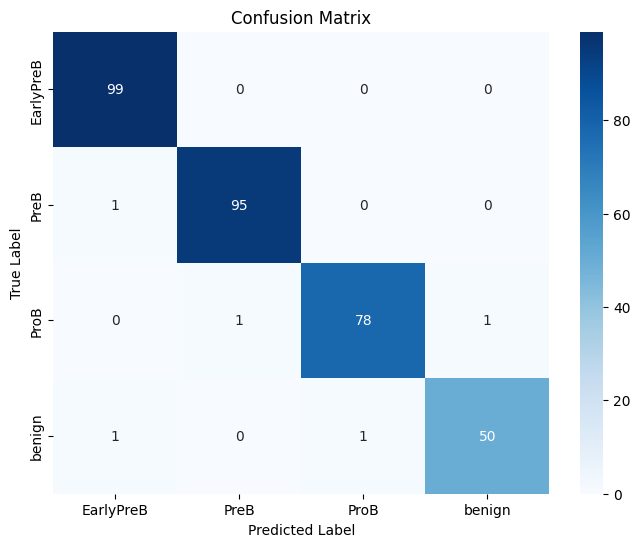

In [76]:
import seaborn as sns
import matplotlib.pyplot as plt

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=class_labels, yticklabels=class_labels)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()
